In [73]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
import numpy as np

## Get match train prepocessed dataset

In [74]:
def feature_preprocess(url, iseval):
    df = pd.read_csv(f'../tweets/{url}.csv')
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='ms')
    results = []
    
    for match_id, match_data in df.groupby('MatchID'):
        start_time = match_data['Timestamp'].min()
        match_data['Minute'] = (match_data['Timestamp'] - start_time).dt.total_seconds() // 60
        
        data_per_minute = match_data.groupby('Minute')
        tweet_count_per_minute = data_per_minute.size()
        max_tweet_count = max(tweet_count_per_minute)
        min_tweet_count = min(tweet_count_per_minute)
        tweet_count_percentage = (tweet_count_per_minute - min_tweet_count) / (max_tweet_count - min_tweet_count)
        
        key_events = ['goal', 'own goal', 'red card', 'yellow card', 'penalty', 'match start', 'match end', 'half time']
        
        for minute, group in data_per_minute:
            event_tweets = sum(any(f' {event} ' in f' {tweet} ' for event in key_events) for tweet in group['Tweet'])
            proportion = event_tweets / len(group) if len(group) > 0 else 0
            minute_renormalized = minute / 129
            
            if iseval:
                results.append({
                    'ID': f'{match_id}_{minute}',
                    'MatchID': match_id,
                    'MinuteRenormalized': minute_renormalized,
                    'TweetCountPercentage': tweet_count_percentage[minute],
                    'EventProportion': proportion
                })
            else:
                # Take the most common EventType for this minute
                event_type = group['EventType'].mode().iloc[0]
                results.append({
                    'ID': f'{match_id}_{minute}',
                    'MatchID': match_id,
                    'EventType': event_type,
                    'MinuteRenormalized': minute_renormalized,
                    'TweetCountPercentage': tweet_count_percentage[minute],
                    'EventProportion': proportion
                })
    
    results_df = pd.DataFrame(results)
    results_df.to_csv(f'match_analysis_{url}.csv', index=False)

In [75]:
url = 'preprocessed_tweets'
feature_preprocess(url, iseval=False)

In [76]:
df = pd.read_csv('match_analysis_preprocessed_tweets.csv')

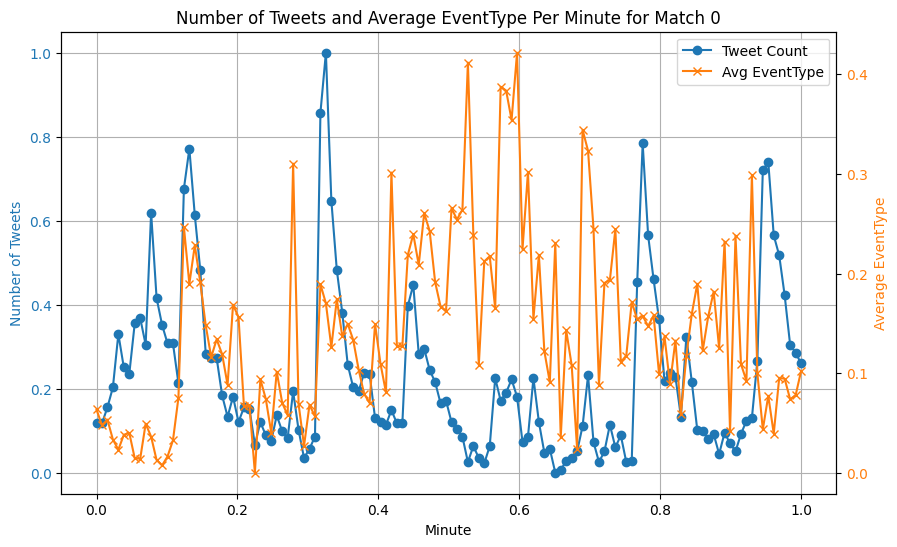

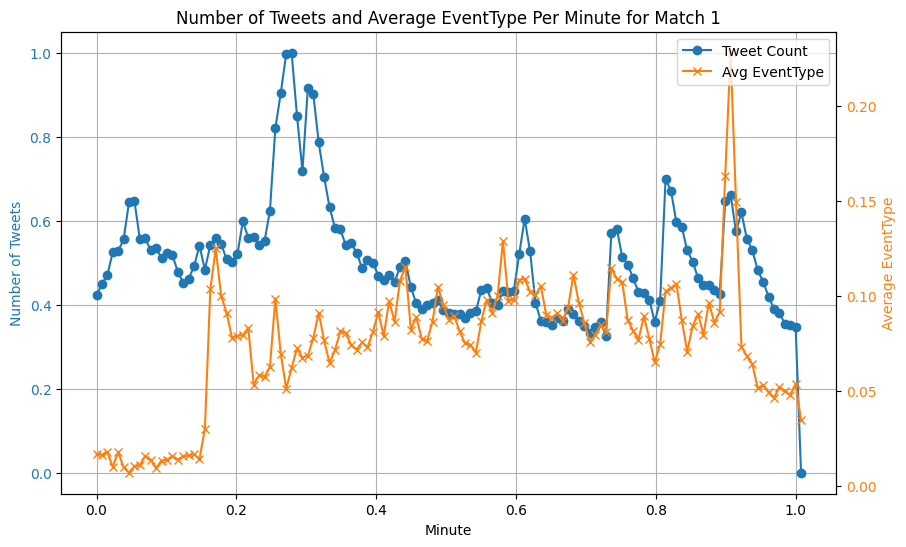

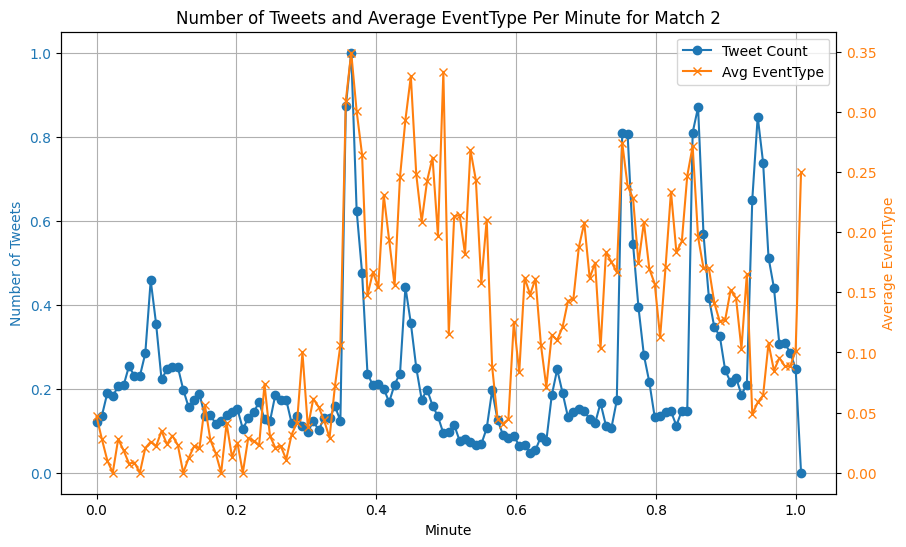

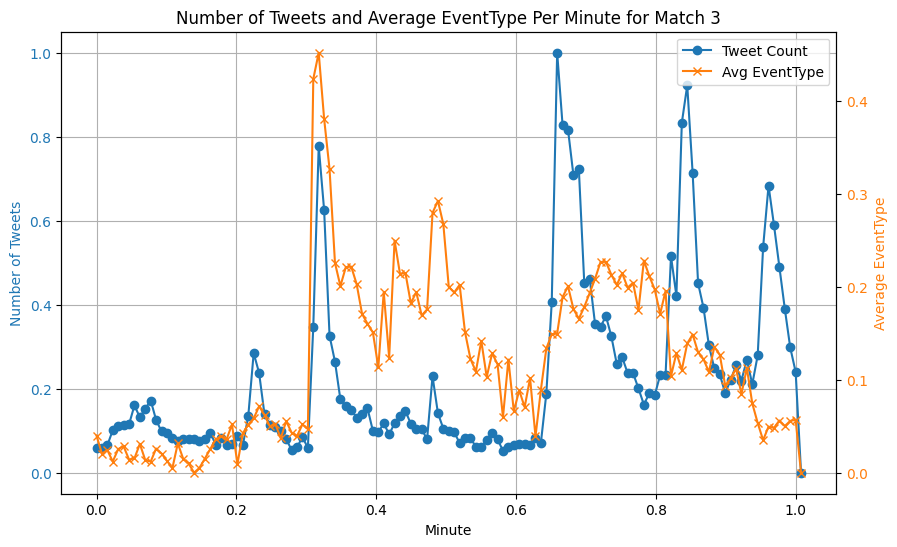

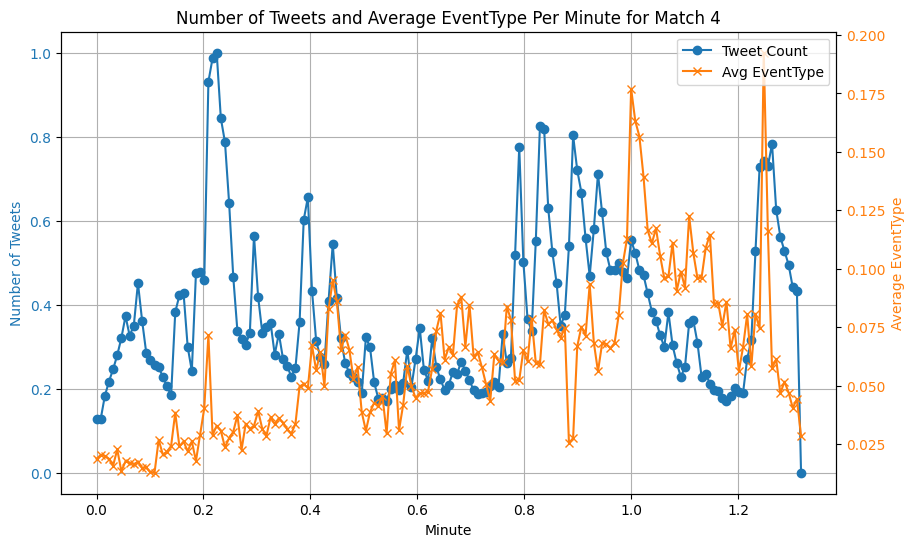

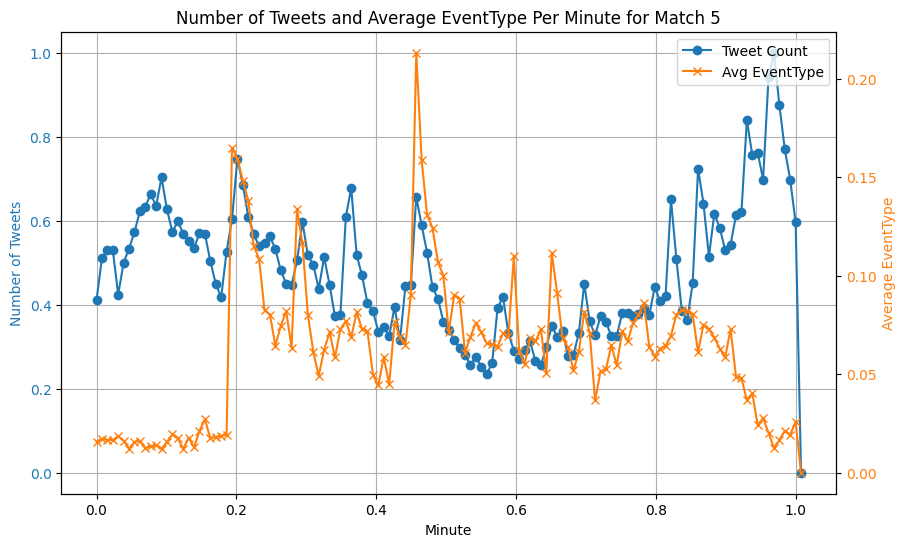

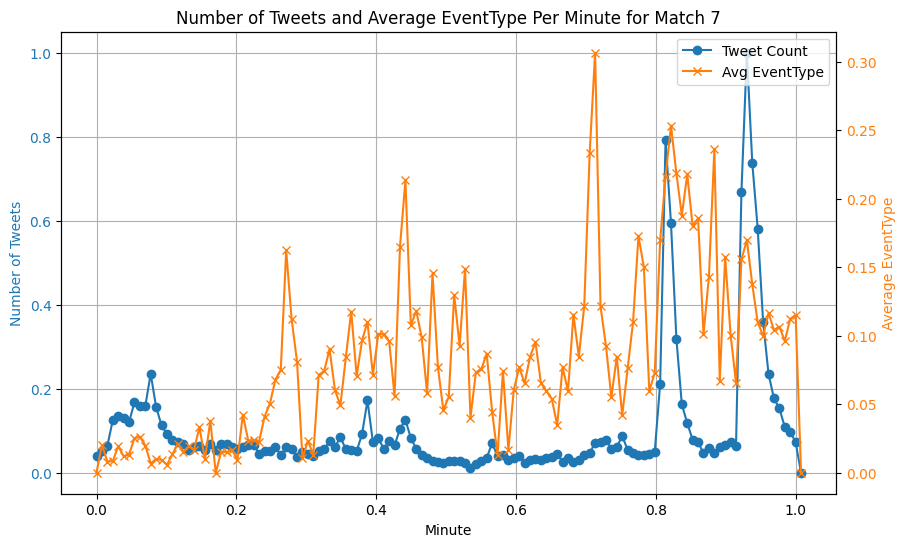

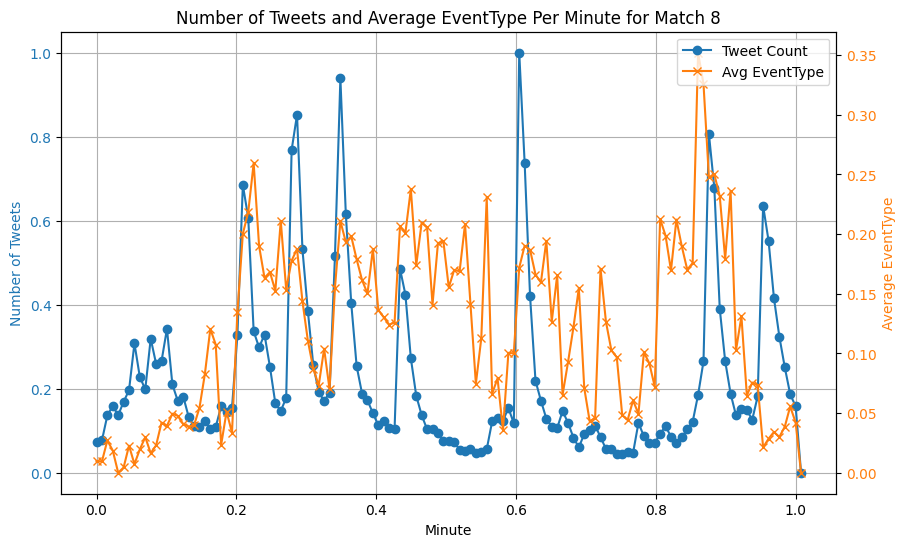

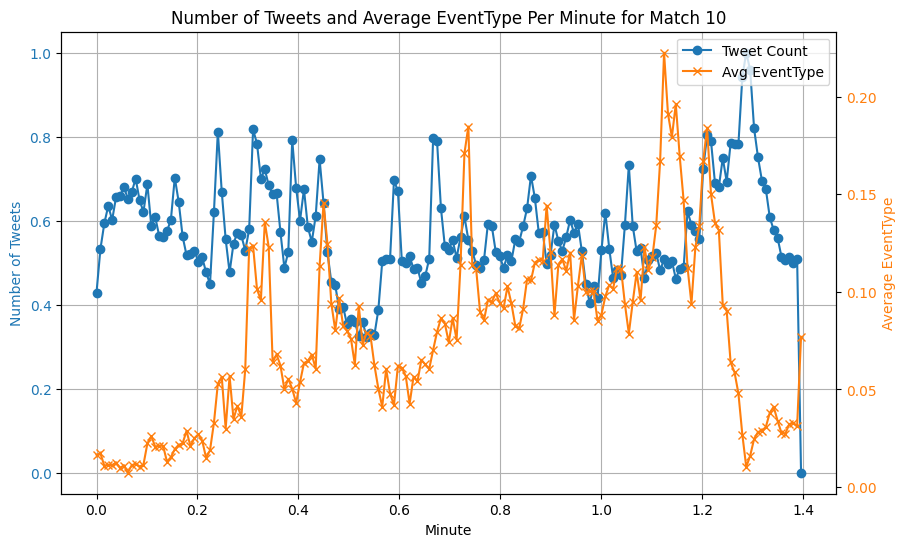

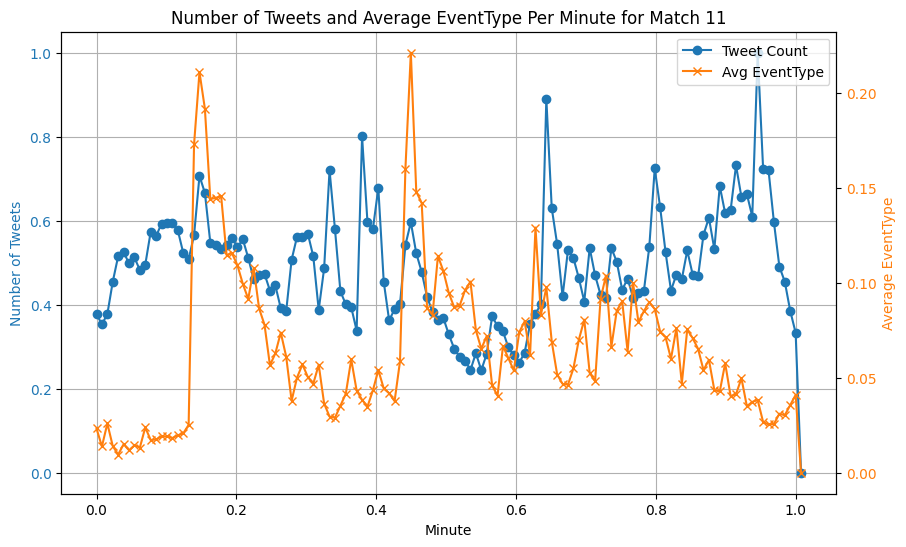

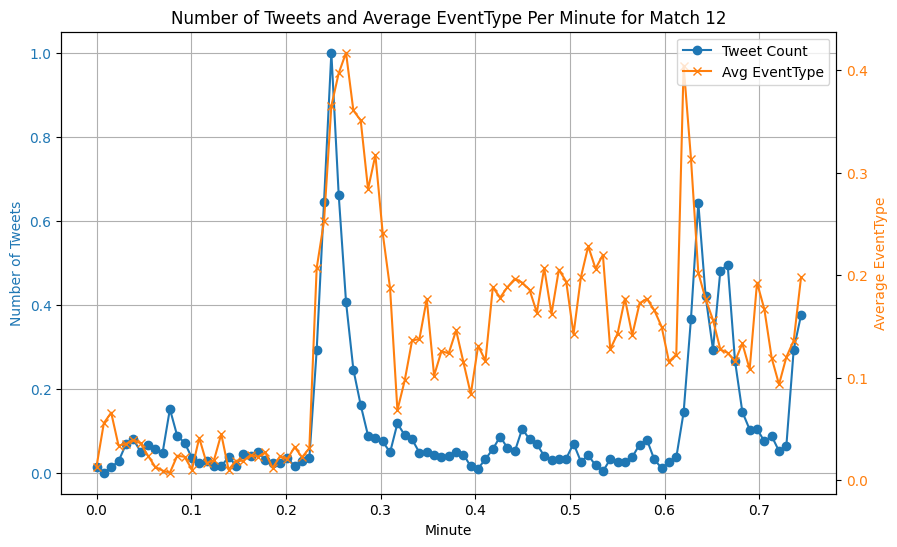

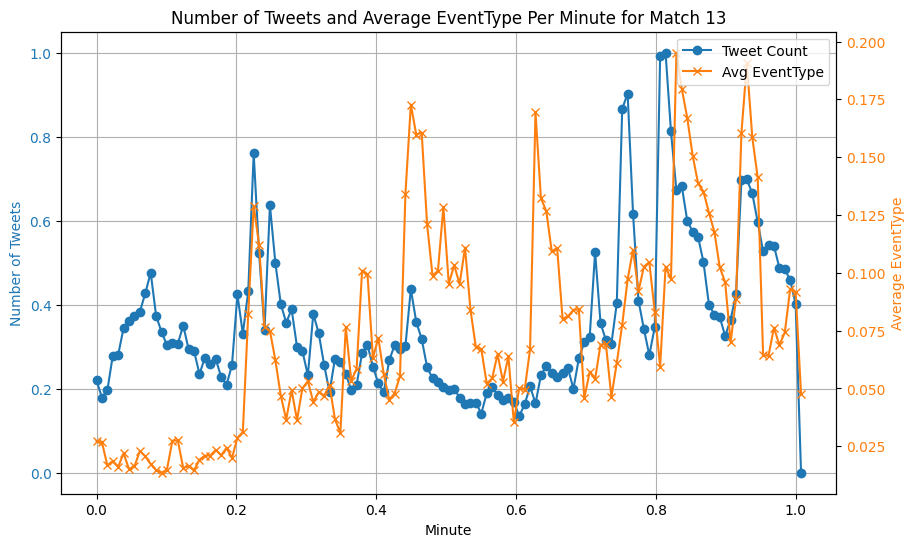

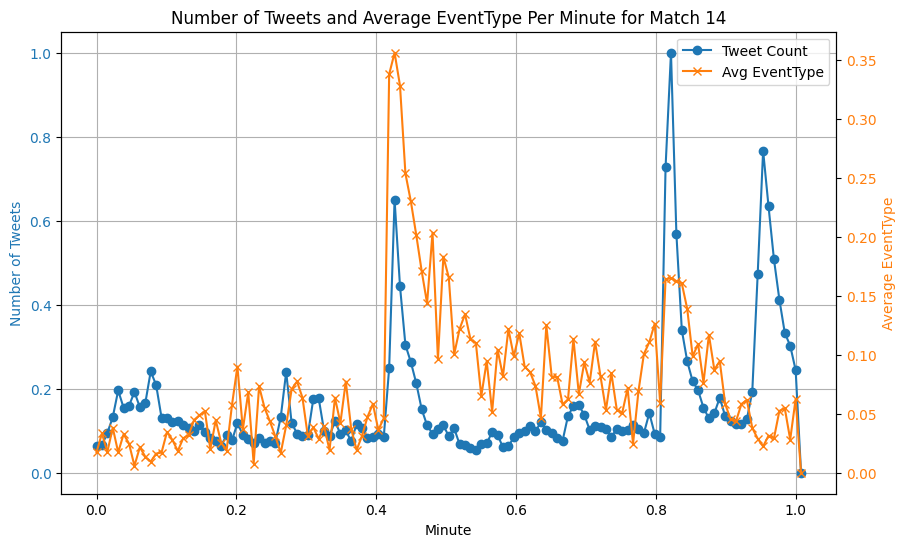

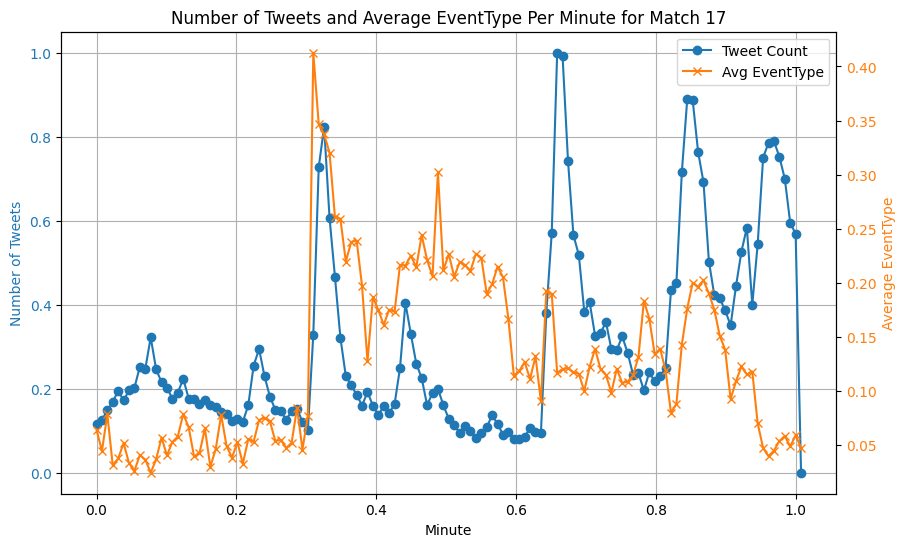

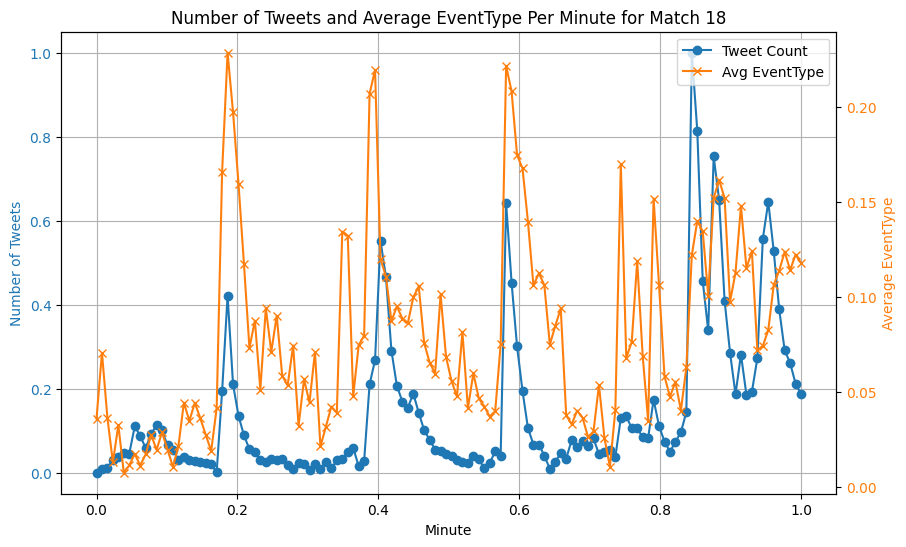

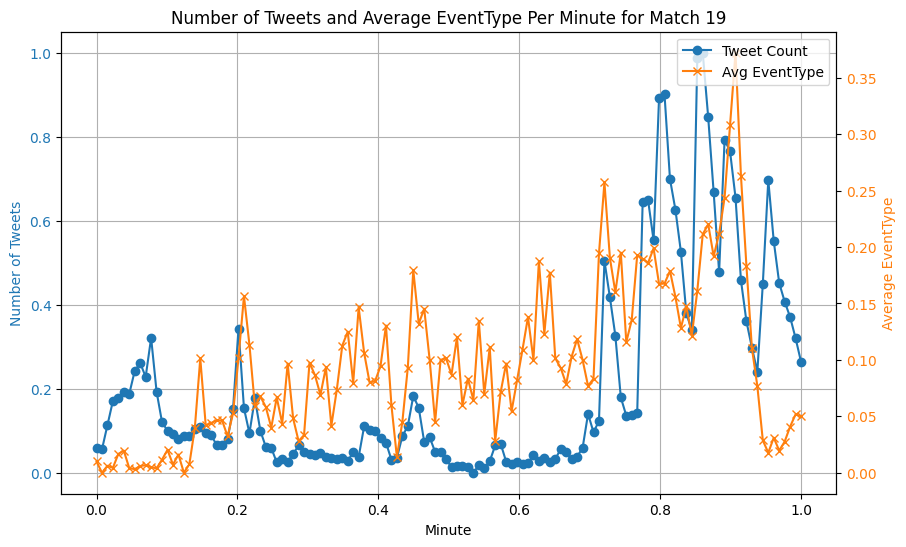

In [77]:
for match_id, match_data in df.groupby('MatchID'):
    minute = match_data['MinuteRenormalized']  # Remove comma
    tweet_count = match_data['TweetCountPercentage']  # Use match_data
    eventproportion = match_data['EventProportion']  # Use match_data
    
    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.set_xlabel('Minute')
    ax1.set_ylabel('Number of Tweets', color='tab:blue')
    ax1.plot(minute, tweet_count, marker='o', color='tab:blue', label='Tweet Count')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Average EventType', color='tab:orange')
    ax2.plot(minute, eventproportion, marker='x', color='tab:orange', label='Avg EventType')
    ax2.tick_params(axis='y', labelcolor='tab:orange')

    plt.title(f'Number of Tweets and Average EventType Per Minute for Match {match_id}')
    ax1.grid(True)
    
    # Add legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    plt.show()

In [78]:
url = 'eval_cleaned_tweets'
feature_preprocess(url, iseval=True)